#Setup & Imports

In [2]:
import os, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import precision_recall_curve, accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, f1_score
from collections import Counter, defaultdict
from google.colab import drive
from torch import amp
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
from scipy.signal import resample_poly
from fractions import Fraction

#Config & Utils

In [3]:
# ====================== Setup: Device & Reproducibility ======================

def seed_everything(seed: int = 42):
    """Seed Python, NumPy, and PyTorch for (mostly) reproducible runs.

    This sets seeds for Python's `random`, NumPy, and PyTorch (CPU & all CUDA
    devices), and configures cuDNN for deterministic behavior. Note that full
    determinism is not guaranteed across different hardware/driver versions,
    but this is a strong baseline for repeatability.

    Args:
        seed: The seed to use for all RNGs.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For maximum reproducibility (slightly slower but more stable)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Choose the device once and use it consistently throughout the codebase
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_everything(42)

print(f"Using device: {device}")
if device.type == "cuda":
    try:
        # Commonly acceptable for classification with Cross-Entropy (CE).
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        print("TF32 enabled for CUDA backends.")
    except Exception:
        pass


Using device: cuda
TF32 enabled for CUDA backends.


#Load Dataset

In [4]:
# ─── Mount GDrive ────────────────────────────────────────────────────────────────
drive.mount('/content/drive')
print("Drive mounted at /content/drive")


# ─── Generic loader that supports both ECG5000 ─────
def load_ecg_all_from_gdrive(gdrive_dir, dataset="ecg5000", verbose=True):
    """
    Load ECG dataset from Google Drive.

    Args:
      gdrive_dir (str): directory containing the dataset files.
      dataset (str): "ecg5000" for UCR .txt files.
      verbose (bool)

    Returns:
      X_all (np.ndarray, float32) shape [N, L]
      y_all (np.ndarray, int64)   shape [N]  (binary: 0=Normal, 1=Abnormal)
      meta  (dict): {'name','paths','seq_len','labels_raw'}
    """
    dataset = dataset.lower().strip()

    if dataset == "ecg5000":
        # Expect: ECG5000_TRAIN.txt + ECG5000_TEST.txt (UCR format)
        train_path = os.path.join(gdrive_dir, "ECG5000_TRAIN.txt")
        test_path  = os.path.join(gdrive_dir, "ECG5000_TEST.txt")
        if not (os.path.exists(train_path) and os.path.exists(test_path)):
            raise FileNotFoundError(
                f"ECG5000 files not found in: {gdrive_dir}\n"
                f"Expected 'ECG5000_TRAIN.txt' and 'ECG5000_TEST.txt'."
            )
        if verbose:
            print(f"Loading ECG5000 (UCR .txt):\n  TRAIN: {train_path}\n  TEST:  {test_path}")

        # UCR: first column = label, rest = samples
        df_tr = pd.read_csv(train_path, header=None, sep=r"\s+", engine="python")
        df_te = pd.read_csv(test_path,  header=None, sep=r"\s+", engine="python")
        df_all = pd.concat([df_tr, df_te], ignore_index=True)

        X_all = df_all.iloc[:, 1:].to_numpy(dtype=np.float32)
        y_raw = df_all.iloc[:, 0].to_numpy(dtype=int)

        # Binary map: min(label)->0 (Normal), others->1 (Abnormal)  (ECG5000: 1 is min=Normal)
        y_all = (y_raw != y_raw.min()).astype(np.int64)

        meta = {
            "name": "ECG5000",
            "paths": {"train": train_path, "test": test_path},
            "seq_len": int(X_all.shape[1]),
            "labels_raw": np.unique(y_raw).tolist(),
        }

    else:
        raise ValueError("dataset must be one of: 'ecg5000', 'mitbih_csv'")

    if verbose:
        n0 = int((y_all == 0).sum()); n1 = int((y_all == 1).sum())
        print(f"Loaded {meta['name']} | X_all: {X_all.shape}, y_all: {y_all.shape}")
        print(f"Class balance -> Normal(0): {n0} | Abnormal(1): {n1} | Pos%: {100*n1/len(y_all):.1f}%")

    return X_all, y_all, meta

# ─── Usage ─────────────────────────────────────────────────────────────
# ECG5000 (UCR .txt)
GDRIVE_DATASET_DIR = "/content/drive/MyDrive/Colab Notebooks/ECG5000"   # <-Put the right directory
X_all_raw, y_all, meta = load_ecg_all_from_gdrive(GDRIVE_DATASET_DIR, dataset="ecg5000", verbose=True)
SEQ_LEN = X_all_raw.shape[1]
print("Seq len:", SEQ_LEN)

Mounted at /content/drive
Drive mounted at /content/drive
Loading ECG5000 (UCR .txt):
  TRAIN: /content/drive/MyDrive/Colab Notebooks/ECG5000/ECG5000_TRAIN.txt
  TEST:  /content/drive/MyDrive/Colab Notebooks/ECG5000/ECG5000_TEST.txt
Loaded ECG5000 | X_all: (5000, 140), y_all: (5000,)
Class balance -> Normal(0): 2919 | Abnormal(1): 2081 | Pos%: 41.6%
Seq len: 140


# Train/Val/Test Split + Scaling

In [5]:
# 60/20/20 stratified split: first split 80/20 (temp/test), then 75/25 within the 80% (train/val)
X_temp, X_te, y_temp, y_te = train_test_split(
    X_all_raw, y_all, test_size=0.20, random_state=42, stratify=y_all
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)  # 0.25 from 0.80 = 0.20

def zscore_per_sample(X: np.ndarray, eps: float = 1e-6, clip: float | None = 6.0) -> np.ndarray:
    """Compute a per-sample Z-score along the time axis.

    Supports inputs of shape (N, L) and (N, L, C). The mean and std are computed
    along axis=1 (time), preserving the remaining dimensions. Optionally clips
    extreme values for robustness.

    Args:
        X: Input array of shape (N, L) or (N, L, C).
        eps: Small constant to avoid division by zero in standard deviation.
        clip: If provided, clip the standardized values to [-clip, clip].

    Returns:
        Array with the same shape as ``X`` (dtype float32) after per-sample standardization.

    Raises:
        ValueError: If ``X.ndim`` is not 2 or 3.
    """
    X = np.asarray(X, dtype=np.float64)
    if X.ndim not in (2, 3):
        raise ValueError(f"expected X.ndim in {{2,3}}, got {X.ndim}")
    mu = X.mean(axis=1, keepdims=True)                  # (N, 1) or (N, 1, C)
    sd = X.std(axis=1, keepdims=True)
    Z = (X - mu) / np.maximum(sd, eps)
    if clip is not None:
        Z = np.clip(Z, -clip, clip)
    return Z.astype(np.float32)

# Keep raw copies before normalization (used later for multi-channel features)
X_tr_raw, X_val_raw, X_te_raw = X_tr, X_val, X_te

# Per-sample Z-score for the baseline (single channel)
X_tr  = zscore_per_sample(X_tr_raw,  eps=1e-6, clip=6.0)
X_val = zscore_per_sample(X_val_raw, eps=1e-6, clip=6.0)
X_te  = zscore_per_sample(X_te_raw,  eps=1e-6, clip=6.0)

print("Final shapes (baseline):", X_tr.shape, X_val.shape, X_te.shape)

# Check sizes and class distributions
def show_counts(y, name):
    """Print a short class-count summary for a binary label vector.

    Args:
        y: 1D array of integer labels (assumed binary: {0,1}).
        name: A label for this split (e.g., 'Train (60%)').
    """
    cnt = np.bincount(y)
    print(f"{name}: N={len(y)} | 0={cnt[0]} | 1={cnt[1]} | pos%={100*cnt[1]/len(y):.1f}%")

show_counts(y_tr,  "Train (60%)")
show_counts(y_val, "Val   (20%)")
show_counts(y_te,  "Test  (20%)")
print("Final shapes:", X_tr.shape, X_val.shape, X_te.shape)


Final shapes (baseline): (3000, 140) (1000, 140) (1000, 140)
Train (60%): N=3000 | 0=1751 | 1=1249 | pos%=41.6%
Val   (20%): N=1000 | 0=584 | 1=416 | pos%=41.6%
Test  (20%): N=1000 | 0=584 | 1=416 | pos%=41.6%
Final shapes: (3000, 140) (1000, 140) (1000, 140)


#Datasets & Dataloaders (Binary)

In [6]:
class ECGBinaryDataset(Dataset):
    """Torch Dataset for binary ECG sequences.

    Expects inputs shaped as:
      - (N, L) for single-channel signals, or
      - (N, L, C) for multi-channel signals.

    If ``channels == 1`` and X is (N, L), it will be expanded to (N, L, 1).

    Args:
        X: Array of shape (N, L) or (N, L, C).
        y: Binary labels of shape (N,), values in {0, 1}.
        channels: Number of channels (1 means expand last dim if missing).
    """
    def __init__(self, X, y, channels=1):
        # If a single channel is requested, expand (N, L) -> (N, L, 1)
        if channels == 1:
            X = X[:, :, None]  # (N, L, 1)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def make_loaders(X_tr, y_tr, X_val, y_val, X_te, y_te, batch_size=64, channels=1):
    """Create DataLoaders for train/val/test with a class-balanced sampler for train.

    The training loader uses a ``WeightedRandomSampler`` with weights
    inversely proportional to class frequency in the training set.
    Validation and test loaders use deterministic ordering (no shuffling).

    Args:
        X_tr, y_tr: Training features and labels.
        X_val, y_val: Validation features and labels.
        X_te, y_te: Test features and labels.
        batch_size: Batch size for all loaders.
        channels: Number of channels to use in the dataset.

    Returns:
        (train_loader, val_loader, test_loader)
    """
    #Datasets
    train_ds = ECGBinaryDataset(X_tr, y_tr, channels=channels)
    val_ds   = ECGBinaryDataset(X_val, y_val, channels=channels)
    test_ds  = ECGBinaryDataset(X_te, y_te, channels=channels)

    # ----- WeightedRandomSampler (training only) -----
    # Weight per class is inversely proportional to its frequency in y_tr
    class_counts = np.bincount(y_tr, minlength=2).astype(np.float64)
    # Safe inverse (unused classes won't be indexed by y_tr anyway)
    weight_per_class = 1.0 / class_counts
    sample_weights = weight_per_class[y_tr]            # per-sample weight by class
    sample_weights = sample_weights / sample_weights.mean()  # normalized for convenience

    sampler = WeightedRandomSampler(
        weights=torch.tensor(sample_weights, dtype=torch.float32),
        num_samples=len(sample_weights),
        replacement=True
    )

    # DataLoaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)
    val_loader   = DataLoader(val_ds,  batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Note: y_te (not y_test) is passed here.
train_loader, val_loader, test_loader = make_loaders(
    X_tr, y_tr, X_val, y_val, X_te, y_te, batch_size=64, channels=1
)

#Baseline Transformer Model Infrastructure

In [7]:
class PositionalEncodingBase(nn.Module):
    """Sinusoidal positional encoding (fixed, non-trainable).

    Builds a standard Transformer-style sine/cosine table and registers it as a
    buffer (not a parameter). Can be added to token embeddings/hidden states.

    Args:
        d_model: Embedding (channel) dimension D.
        max_len: Maximum supported sequence length L.

    Notes:
        - Shape of the stored buffer: (1, max_len, d_model).
        - Works for any ``d_model``; if ``d_model`` is odd, the last cosine
          channel is simply omitted due to slicing.
    """
    def __init__(self, d_model, max_len=2048):
        super().__init__()
        pe = torch.zeros(max_len, d_model, dtype=torch.float32)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, L, D)

    def forward(self, x):
        """Add positional encodings to the input.

        Args:
            x: Input tensor of shape (B, L, D).

        Returns:
            Tensor of shape (B, L, D) with positional encodings added.
        """
        # x: (B, L, D)
        return x + self.pe[:, :x.size(1), :]


class Transformer1DBase(nn.Module):
    """Baseline ECG classifier using a Transformer encoder.

    Architecture:
        [Temporal Conv1d stem] → LayerNorm → GELU → PositionalEncoding →
        TransformerEncoder → Global Average Pool (time) → LayerNorm → Classifier MLP

    Args:
        input_dim: Number of input channels C (e.g., 1 for single-lead ECG).
        d_model: Model/embedding dimension D for the Transformer.
        nhead: Number of attention heads.
        num_layers: Number of Transformer encoder layers.
        num_classes: Number of output classes (2 for binary).
        dropout: Dropout probability used in the encoder and classifier head.
        kernel_size: Temporal kernel size for the Conv1d stem (should be odd to preserve length).

    Shapes:
        Input:  (B, L, C)
        Output: (B, num_classes)
    """
    def __init__(self, input_dim=1, d_model=128, nhead=8, num_layers=4,
                 num_classes=2, dropout=0.1, **kwargs):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model, bias=True)
        self.stem_bn    = nn.BatchNorm1d(d_model)
        self.stem_act   = nn.ReLU(inplace=True)

        self.pos_enc = PositionalEncodingBase(d_model)
        enc = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                         dim_feedforward=4*d_model,
                                         dropout=dropout, activation='relu',
                                         batch_first=True)
        self.encoder = nn.TransformerEncoder(enc, num_layers=num_layers)

        self.head_bn = nn.BatchNorm1d(d_model)
        self.cls = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1)  # ← single logit
        )
    def forward(self, x):
        """Forward pass.

        Args:
            x: ECG tensor of shape (B, L, C).

        Returns:
            Logits of shape (B, num_classes).
        """
        x = self.input_proj(x)          # (B, L, D)
        x = x.permute(0, 2, 1)          # (B, D, L)
        x = self.stem_bn(x); x = x.permute(0, 2, 1)  # (B, L, D)
        x = self.stem_act(x)
        x = self.pos_enc(x)
        x = self.encoder(x)             # (B, L, D)
        x = x.mean(dim=1)               # (B, D)
        x = self.head_bn(x)
        logit = self.cls(x).squeeze(1)  # (B,) ← without Softmax/Sigmoid
        return logit

#Ensemble Models Infrastructure



In [8]:
class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding (fixed, non-trainable).

    Builds a standard Transformer-style sine/cosine table and registers it as a
    buffer (not a parameter). Can be added to token embeddings/hidden states.

    Args:
        d_model: Embedding (channel) dimension D.
        max_len: Maximum supported sequence length L.

    Notes:
        - Shape of the stored buffer: (1, max_len, d_model).
        - Works for any ``d_model``; if ``d_model`` is odd, the last cosine
          channel is simply omitted due to slicing.
    """
    def __init__(self, d_model, max_len=2048):
        super().__init__()
        pe = torch.zeros(max_len, d_model, dtype=torch.float32)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model)) #⌈D/2⌉)
        pe[:, 0::2] = torch.sin(position * div_term) # even indices
        pe[:, 1::2] = torch.cos(position * div_term) # odd indices
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, L, D)

    def forward(self, x):
        """Add positional encodings to the input.

        Args:
            x: Input tensor of shape (B, L, D).

        Returns:
            Tensor of shape (B, L, D) with positional encodings added.
        """
        # x: (B, L, D)
        return x + self.pe[:, :x.size(1), :]


class Transformer1D(nn.Module):
    """Baseline ECG classifier using a Transformer encoder.

    Architecture:
        [Temporal Conv1d stem] → LayerNorm → GELU → PositionalEncoding →
        TransformerEncoder → Global Average Pool (time) → LayerNorm → Classifier MLP

    Args:
        input_dim: Number of input channels C (e.g., 1 for single-lead ECG).
        d_model: Model/embedding dimension D for the Transformer.
        nhead: Number of attention heads.
        num_layers: Number of Transformer encoder layers.
        num_classes: Number of output classes (2 for binary).
        dropout: Dropout probability used in the encoder and classifier head.
        kernel_size: Temporal kernel size for the Conv1d stem (should be odd to preserve length).

    Shapes:
        Input:  (B, L, C)
        Output: (B, num_classes)
    """
    def __init__(self, input_dim=1, d_model=128, nhead=8, num_layers=4,
                 num_classes=2, dropout=0.1, kernel_size=7):
        super().__init__()
        assert kernel_size % 2 == 1, "kernel_size should be odd to preserve 'same' length with padding=ks//2"

        # ---- Temporal conv stem (per-time local context) ----
        # Conv1d expects (B, C_in, L); will convert back to (B, L, D) after conv.
        self.stem_conv = nn.Conv1d(in_channels=input_dim, out_channels=d_model,
                                   kernel_size=kernel_size, stride=1, padding=kernel_size//2, bias=True)
        # LayerNorm operates on the last dimension (D) once we are back to (B, L, D).
        self.stem_ln   = nn.LayerNorm(d_model)
        self.stem_act  = nn.GELU()

        # ---- Positional encoding & Transformer encoder ----
        self.pos_enc = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model*4,
            dropout=dropout, activation='gelu', batch_first=True
        )

        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # ---- Classification Head ----
        self.norm = nn.LayerNorm(d_model)
        self.cls = nn.Sequential(
            nn.Linear(d_model, d_model//2), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(d_model//2, num_classes)
        )

    def forward(self, x):
        """Forward pass.

        Args:
            x: ECG tensor of shape (B, L, C).

        Returns:
            Logits of shape (B, num_classes).
        """
        # Conv1d over time:
        x = x.permute(0, 2, 1)                # -> (B, C, L)
        x = self.stem_conv(x)                 # -> (B, D, L)
        x = x.permute(0, 2, 1)                # -> (B, L, D)
        x = self.stem_ln(x)                   # LN per token
        x = self.stem_act(x)                  # GELU

        # Positional encoding + Transformer encoder
        x = self.pos_enc(x)                   # (B, L, D)
        x = self.encoder(x)                   # (B, L, D)

        # Global average pooling over time + head
        x = x.mean(dim=1)                     # GAP -> (B, D)
        x = self.norm(x)
        logits = self.cls(x)                  #(B, num_classes)
        return logits

#Train/Eval Helpers - For Baseline Model

In [9]:
def train_one_epoch_Base(model, loader, criterion, optimizer, grad_clip=1.0):
    """Train for a single epoch.

    - Tracks a batch-size–weighted average loss (robust when the last batch is smaller).
    - Uses Automatic Mixed Precision (AMP) on CUDA via ``torch.amp.autocast`` and ``GradScaler``.
      On CPU or when CUDA is unavailable, AMP is a safe no-op.

    Args:
        model: The model to train.
        loader: Training DataLoader.
        criterion: Loss function (unweighted CrossEntropy for your setup).
        optimizer: Optimizer instance (e.g., AdamW).
        grad_clip: Max-norm gradient clipping; set ``None`` or ``0`` to disable.

    Returns:
        (avg_loss, accuracy_pct) where:
            avg_loss: Mean loss per sample over the epoch.
            accuracy_pct: Accuracy in percent computed via argmax on logits.
    """
    model.train()
    loss_sum, correct, total = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        bs = yb.size(0)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb.float())    # BCE expects float targets
        loss.backward()
        if grad_clip and grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        loss_sum += loss.detach().item() * bs
        preds = (logits >= 0).long()            # logits>=0 ⇔ p≥0.5
        correct += (preds == yb).sum().item()
        total += bs
    return loss_sum / max(1, total), 100.0 * correct / max(1, total)

@torch.no_grad()
def evaluate_model_Base(model, loader, criterion, temperature=None):
    """
    Eval that supports:
      - BCE single-logit: returns probs=sigmoid(logits/T)
      - CE 2-logits:      returns probs=softmax(logits/T)[:,1]
    Returns: avg_loss, acc_pct, y_pred, y_true, y_prob
    """
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    y_prob, y_pred, y_true = [], [], []
    T = float(temperature) if (temperature is not None) else 1.0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)

        # Determine mode by shape
        if out.ndim == 1 or (out.ndim == 2 and out.size(1) == 1):
            logits = out.view(-1)
            # loss with BCE
            try:
                loss = criterion(logits, yb.float())
            except Exception:
                loss = F.binary_cross_entropy_with_logits(logits, yb.float())
            probs = torch.sigmoid(logits / T)
            preds = (logits >= 0).long()
        else:
            logits = out
            # loss with CE
            try:
                loss = criterion(logits, yb.long())
            except Exception:
                loss = F.cross_entropy(logits, yb.long())
            probs = F.softmax(logits / T, dim=1)[:, 1]
            preds = logits.argmax(dim=1)

        bs = yb.size(0)
        loss_sum += loss.item() * bs
        correct += (preds == yb).sum().item()
        total += bs

        y_prob.extend(probs.detach().cpu().numpy().tolist())
        y_pred.extend(preds.detach().cpu().numpy().tolist())
        y_true.extend(yb.detach().cpu().numpy().tolist())

    avg_loss = loss_sum / max(1, total)
    acc_pct  = 100.0 * correct / max(1, total)
    return avg_loss, acc_pct, np.array(y_pred), np.array(y_true), np.array(y_prob)

def fit_Base(model, train_loader, val_loader, epochs=40, base_lr=1e-2, weight_decay=0.0, patience=8):
    """Full training loop with warmup, cosine schedule, and early stopping.

    Behavior:
        - Train uses the provided loader (already class-balanced via WeightedRandomSampler).
        - Validation uses UNWEIGHTED CrossEntropyLoss (no class weights).
        - Model selection & early stopping by PR-AUC (Average Precision).
        - LR schedule: linear warmup (10% of epochs) → cosine annealing.
        - AdamW param groups: no weight decay on bias / LayerNorm parameters.

    Args:
        model: The model to train.
        train_loader: Training DataLoader.
        val_loader: Validation DataLoader.
        epochs: Total training epochs.
        base_lr: Base learning rate after warmup.
        weight_decay: Weight decay for AdamW (except bias/LayerNorm).
        patience: Early stopping patience in epochs (on PR-AUC).

    Returns:
        history: Dict of lists with metrics per epoch
                 {'train_loss','train_acc','val_loss','val_acc','val_pr_auc','val_roc_auc','lr'}.
        best_pr_auc: Best validation PR-AUC achieved.
        best_epoch: 1-based epoch index where best PR-AUC was observed.
    """
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=base_lr)
    criterion = nn.BCEWithLogitsLoss()

    best_state, best_pr_auc, best_epoch = None, -float("inf"), -1
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [],
               'val_pr_auc': [], 'val_roc_auc': [], 'lr': []}
    wait = 0

    for epoch in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch_Base(model, train_loader, criterion, optimizer)
        val_loss, val_acc, _, y_true, y_prob = evaluate_model_Base(model, val_loader, criterion)

        try:
            val_pr_auc = average_precision_score(y_true, y_prob)
        except Exception:
            val_pr_auc = float("nan")
        if len(np.unique(y_true)) == 2:
            try:
                val_roc_auc = roc_auc_score(y_true, y_prob)
            except Exception:
                val_roc_auc = float("nan")
        else:
            val_roc_auc = float("nan")

        history['train_loss'].append(tr_loss); history['train_acc'].append(tr_acc)
        history['val_loss'].append(val_loss);   history['val_acc'].append(val_acc)
        history['val_pr_auc'].append(val_pr_auc); history['val_roc_auc'].append(val_roc_auc)
        history['lr'].append(base_lr)

        print(f"Epoch {epoch:03d} | lr {base_lr:.2e} | train {tr_loss:.4f}/{tr_acc:.2f}% "
              f"| val {val_loss:.4f}/{val_acc:.2f}% | PR-AUC {val_pr_auc:.4f} ROC-AUC {val_roc_auc:.4f}")

        if val_pr_auc > best_pr_auc:
            best_pr_auc, best_state, best_epoch = val_pr_auc, {k: v.cpu() for k, v in model.state_dict().items()}, epoch
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state, strict=True)
    return history, best_pr_auc, best_epoch

#Train/Eval Helpers - For Ensemble models

In [10]:
def train_one_epoch(model, loader, criterion, optimizer, grad_clip=1.0):
    """Train for a single epoch.

    - Tracks a batch-size–weighted average loss (robust when the last batch is smaller).
    - Uses Automatic Mixed Precision (AMP) on CUDA via ``torch.amp.autocast`` and ``GradScaler``.
      On CPU or when CUDA is unavailable, AMP is a safe no-op.

    Args:
        model: The model to train.
        loader: Training DataLoader.
        criterion: Loss function (unweighted CrossEntropy for your setup).
        optimizer: Optimizer instance (e.g., AdamW).
        grad_clip: Max-norm gradient clipping; set ``None`` or ``0`` to disable.

    Returns:
        (avg_loss, accuracy_pct) where:
            avg_loss: Mean loss per sample over the epoch.
            accuracy_pct: Accuracy in percent computed via argmax on logits.
    """
    model.train()

    # AMP is used only when CUDA is available
    use_amp = (torch.cuda.is_available() and device.type == "cuda")
    scaler = amp.GradScaler(device="cuda", enabled=use_amp)


    loss_sum, correct, total = 0.0, 0, 0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        bs = yb.size(0)

        optimizer.zero_grad(set_to_none=True)

        # Forward + loss under autocast only on CUDA (no-op otherwise)
        with amp.autocast(device_type="cuda", enabled=use_amp):
            logits = model(xb)
            loss = criterion(logits, yb)  # UNWEIGHTED CE

        if use_amp:
            # Scaled backward; unscale before clipping
            scaler.scale(loss).backward()
            if grad_clip:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            if grad_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

        # Accumulate batch-size–weighted loss; divide by total at the end
        loss_sum += loss.detach().item() * bs

       # Accuracy via argmax on logits (equivalent to argmax on softmax)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += bs

     # Mean loss per sample + accuracy in %
    avg_loss = loss_sum / max(1, total)
    acc_pct  = 100.0 * correct / max(1, total)
    return avg_loss, acc_pct

@torch.no_grad()
def evaluate_model(model, loader, criterion, temperature=None):
    """Evaluate on a DataLoader.

    Returns:
        avg_loss (per-sample), accuracy % (argmax), y_pred (argmax), y_true (0/1),
        y_prob (class-1 probability; temperature-scaled if provided).

    Notes:
        - ``criterion`` should be UNWEIGHTED for val/test (e.g., ``nn.CrossEntropyLoss()``).
        - If ``temperature`` is given, logits are divided by T before softmax to
          produce calibrated probabilities (does not change argmax for T>0).
        - Thresholding (tau) is handled outside this function.
    """
    model.eval()
    use_amp = (torch.cuda.is_available() and device.type == "cuda")

    loss_sum, correct, total = 0.0, 0, 0
    all_probs, all_targets, all_preds = [], [], []

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        bs = yb.size(0)

        # Forward (AMP on CUDA)
        with amp.autocast(device_type="cuda", enabled=use_amp):
            logits = model(xb)
            loss = criterion(logits, yb)  # UNWEIGHTED CE

        # Accumulate batch-size–weighted loss
        loss_sum += loss.item() * bs

        # Temperature scaling for probabilities only (argmax unaffected for T>0)
        logits_T = logits / float(temperature) if (temperature is not None) else logits

        # Positive-class probability from softmax over 2 logits
        probs = F.softmax(logits_T, dim=1)[:, 1]
        preds = logits.argmax(dim=1)  # hard predictions for accuracy

        all_probs.extend(probs.detach().cpu().numpy().tolist())
        all_preds.extend(preds.detach().cpu().numpy().tolist())
        all_targets.extend(yb.detach().cpu().numpy().tolist())

        correct += (preds == yb).sum().item()
        total += bs

    avg_loss = loss_sum / max(1, total)          # mean per-sample loss
    acc = 100.0 * correct / max(1, total)
    return avg_loss, acc, np.array(all_preds), np.array(all_targets), np.array(all_probs)

def fit(model, train_loader, val_loader, epochs=40, base_lr=1e-3, weight_decay=1e-2, patience=8):
    """Full training loop with warmup, cosine schedule, and early stopping.

    Behavior:
        - Train uses the provided loader (already class-balanced via WeightedRandomSampler).
        - Validation uses UNWEIGHTED CrossEntropyLoss (no class weights).
        - Model selection & early stopping by PR-AUC (Average Precision).
        - LR schedule: linear warmup (10% of epochs) → cosine annealing.
        - AdamW param groups: no weight decay on bias / LayerNorm parameters.

    Args:
        model: The model to train.
        train_loader: Training DataLoader.
        val_loader: Validation DataLoader.
        epochs: Total training epochs.
        base_lr: Base learning rate after warmup.
        weight_decay: Weight decay for AdamW (except bias/LayerNorm).
        patience: Early stopping patience in epochs (on PR-AUC).

    Returns:
        history: Dict of lists with metrics per epoch
                 {'train_loss','train_acc','val_loss','val_acc','val_pr_auc','val_roc_auc','lr'}.
        best_pr_auc: Best validation PR-AUC achieved.
        best_epoch: 1-based epoch index where best PR-AUC was observed.
    """
    model.to(device)

   # --- AdamW param groups: exclude bias and LayerNorm (1D params) from weight decay ---
    decay_params, no_decay_params = [], []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if name.endswith(".bias") or p.ndim == 1:
            no_decay_params.append(p)
        else:
            decay_params.append(p)

    optimizer = optim.AdamW(
        [
            {"params": decay_params, "weight_decay": weight_decay},
            {"params": no_decay_params, "weight_decay": 0.0},
        ],
        lr=base_lr,
    )

    criterion = nn.CrossEntropyLoss()  # UNWEIGHTED for train/val

    # --- LR schedule: warmup (10% epochs) -> cosine annealing ---
    warmup_epochs = max(1, int(0.1 * epochs))
    cosine_epochs = max(1, epochs - warmup_epochs)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=cosine_epochs, eta_min=base_lr * 0.1
    )

    best_state, best_pr_auc, best_epoch = None, -float("inf"), -1
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [],   'val_acc': [],
        'val_pr_auc': [], 'val_roc_auc': [],
        'lr': []
    }
    wait = 0

    for epoch in range(1, epochs + 1):
        # --- Linear warmup to base_lr ---
        if epoch <= warmup_epochs:
            curr_lr = base_lr * float(epoch) / float(warmup_epochs)
            for pg in optimizer.param_groups:
                pg['lr'] = curr_lr
        else:
            curr_lr = optimizer.param_groups[0]['lr']  # לפני צעד ה-scheduler

        # --- Train one epoch ---
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)

        # --- Validate (UNWEIGHTED) ---
        val_loss, val_acc, _, y_true, y_prob = evaluate_model(model, val_loader, criterion)

        # Threshold-free metrics
        try:
            val_pr_auc = average_precision_score(y_true, y_prob)
        except Exception:
            val_pr_auc = float("nan")
        if len(np.unique(y_true)) == 2:
            try:
                val_roc_auc = roc_auc_score(y_true, y_prob)
            except Exception:
                val_roc_auc = float("nan")
        else:
            val_roc_auc = float("nan")

        # --- Logging ---
        history['train_loss'].append(tr_loss); history['train_acc'].append(tr_acc)
        history['val_loss'].append(val_loss);   history['val_acc'].append(val_acc)
        history['val_pr_auc'].append(val_pr_auc); history['val_roc_auc'].append(val_roc_auc)
        history['lr'].append(curr_lr)

        print(
            f"Epoch {epoch:03d} | lr {curr_lr:.2e} "
            f"| train loss {tr_loss:.4f} acc {tr_acc:.2f}% "
            f"| val loss {val_loss:.4f} acc {val_acc:.2f}% "
            f"| PR-AUC {val_pr_auc:.4f} ROC-AUC {val_roc_auc:.4f}"
        )

        # --- Model selection & early stopping by PR-AUC ---
        improved = (val_pr_auc > best_pr_auc)
        if improved:
            best_pr_auc, best_state, best_epoch = val_pr_auc, {k: v.cpu() for k, v in model.state_dict().items()}, epoch
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping.")
                break

        # --- Scheduler step (after the epoch) ---
        if epoch > warmup_epochs:
            scheduler.step()

    if best_state is not None:
        model.load_state_dict(best_state, strict=True)

    # Return history + selection metric + best epoch index
    return history, best_pr_auc, best_epoch

#Utilities - baseline

In [11]:
# === Calibration & Threshold Utilities (F1-oriented, no FN/precision floors) ===
@torch.no_grad()
def _cache_logits_targets(model, loader):
    model.eval()
    logits_list, targets_list = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        logits_list.append(out.detach())
        targets_list.append(yb.detach())
    logits  = torch.cat(logits_list, dim=0)
    targets = torch.cat(targets_list, dim=0)
    return logits, targets

def learn_temperature_Base(model, val_loader, max_iter=50, lr=1e-2):
    """
    Learn scalar T by minimizing CE (for 2-logits) or BCEWithLogits (for 1-logit) on validation logits.
    Applies scaling as logits/T. Returns float(T).
    """
    logits, targets = _cache_logits_targets(model, val_loader)

    # Detect binary single-logit vs multi-class
    is_binary_single = (logits.ndim == 1) or (logits.ndim == 2 and logits.size(1) == 1)

    log_T = torch.zeros(1, device=logits.device, requires_grad=True)  # T = exp(log_T) > 0
    optimizer = torch.optim.LBFGS([log_T], lr=lr, max_iter=max_iter)

    def closure():
        optimizer.zero_grad(set_to_none=True)
        T = torch.exp(log_T) + 1e-8
        scaled = logits / T
        if is_binary_single:
            loss = F.binary_cross_entropy_with_logits(scaled.view(-1), targets.float())
        else:
            loss = F.cross_entropy(scaled, targets.long())
        loss.backward()
        return loss

    optimizer.step(closure)
    T = torch.exp(log_T).detach().item()
    return float(T)

def select_threshold_by_fbeta_Base(y_true, y_prob, beta=1.0):
    """Return tau maximizing F_beta over validation probabilities."""
    prec, rec, ths = precision_recall_curve(y_true, y_prob)
    if len(ths) == 0:
        return 0.5, 0.0, 0.0, 0.0
    prec = np.asarray(prec[:-1]); rec = np.asarray(rec[:-1])
    beta2 = beta * beta
    f = (1.0 + beta2) * (prec * rec) / np.maximum(beta2 * prec + rec, 1e-12)
    i = int(np.nanargmax(f))
    return float(ths[i]), float(f[i]), float(prec[i]), float(rec[i])
def plot_pr_with_point(y_true, y_prob, th, title='PR Curve'):
    """Plot the Precision-Recall curve and mark the operating point at threshold `th`.

    Args:
        y_true: Ground-truth binary labels (0/1).
        y_prob: Predicted positive-class probabilities.
        th: Threshold for the operating point.
        title: Plot title.
    """
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    plt.figure(figsize=(6,4))
    plt.plot(rec, prec, label=f"PR (AP={ap:.4f})")
    yp = (y_prob >= th).astype(int)
    # Precision at the operating point (guard for 0 positives predicted)
    p = (yp[y_true==1].sum()) / max(1, yp.sum()) if yp.sum()>0 else 0.0
    # Recall at the operating point
    r = (yp[y_true==1].sum()) / max(1, (y_true==1).sum())
    plt.scatter([r],[p], s=60, label=f"op: P={p:.3f}, R={r:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(title)
    plt.grid(True, alpha=0.3); plt.legend(loc="lower left"); plt.show()

def plot_cm_counts_percent(cm, total=None, labels=('Normal','Abnormal'), title='Confusion Matrix (test)'):
    """Plot a 2x2 confusion matrix with counts and percentages in each cell.

    For each cell, two lines are shown:
      - First line: raw count
      - Second line: percentage out of `total` (defaults to `cm.sum()`)

    Args:
        cm: Confusion matrix of shape (2, 2).
        total: Total number of samples; if None, uses `cm.sum()`.
        labels: Class labels for axes (true on y-axis, predicted on x-axis).
        title: Plot title.

    Raises:
        ValueError: If `cm` is not of shape (2, 2).
    """
    cm = np.asarray(cm, dtype=np.int64)
    if cm.shape != (2, 2):
        raise ValueError(f"expected 2x2 cm, got shape {cm.shape}")
    if total is None:
        total = int(cm.sum())

    ann = np.empty_like(cm).astype(object)
    for i in range(2):
        for j in range(2):
            pct = 100.0 * cm[i, j] / max(1, total)
            ann[i, j] = f"{cm[i, j]}\n({pct:.1f}%)"

    plt.figure(figsize=(5,4))
    ax = sns.heatmap(cm, annot=ann, fmt='', cbar=True,
                     xticklabels=list(labels), yticklabels=list(labels))
    ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title(title)
    plt.tight_layout(); plt.show()



#Utilities - Ensemble

In [12]:
# === Calibration & Threshold Utilities (F1-oriented, no FN/precision floors) ===
def learn_temperature(model, val_loader, class_weights=None, max_iter=50, lr=1e-2):
    """Learn a scalar temperature T on the validation set WITHOUT backpropagating
    through the model. Logits are cached (no grad) and only T is optimized.

    Notes:
        - Uses unweighted CrossEntropy for calibration (val loss is not class-weighted).
        - T is learned with LBFGS over the cached logits.

    Args:
        model: Trained model in eval mode for generating validation logits.
        val_loader: Validation DataLoader.
        class_weights: Unused placeholder for API compatibility (kept as-is).
        max_iter: Maximum iterations for LBFGS.
        lr: Learning rate for LBFGS.

    Returns:
        The learned temperature as a Python float.
    """
    model.eval()

    # 1) Cache validation logits & targets WITHOUT grad
    all_logits, all_targets = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            all_logits.append(model(xb).detach())
            all_targets.append(yb.detach())
    logits  = torch.cat(all_logits, dim=0)   # [N, num_classes]
    targets = torch.cat(all_targets, dim=0)  # [N]

    # 2) Optimize scalar T only (unweighted CE)
    T = nn.Parameter(torch.ones(1, device=device))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.LBFGS([T], lr=lr, max_iter=max_iter)

    def _closure():
        optimizer.zero_grad(set_to_none=True)
        loss = criterion(logits / T, targets)  # gradients flow only to T
        loss.backward()
        return loss

    optimizer.step(_closure)
    return float(T.detach().item())

def select_threshold_by_fbeta(y_true, y_prob, beta=1.0):
    """Select a probability threshold tau that maximizes F_beta on validation data.

    Args:
        y_true: Ground-truth binary labels (0/1), shape (N,).
        y_prob: Predicted positive-class probabilities, shape (N,).
        beta: F-beta weight (beta=1 → F1).

    Returns:
        (tau, best_f, best_precision, best_recall)
    """
    prec, rec, ths = precision_recall_curve(y_true, y_prob)
    prec = prec[:-1]; rec = rec[:-1]  # align lengths
    beta2 = beta * beta
    f = (1.0 + beta2) * (prec * rec) / np.maximum(beta2 * prec + rec, 1e-12)
    if len(f) == 0:
        return 0.5, 0.0, 0.0, 0.0
    i = int(np.nanargmax(f))
    return float(ths[i]), float(f[i]), float(prec[i]), float(rec[i])

def plot_pr_with_point(y_true, y_prob, th, title='PR Curve'):
    """Plot the Precision-Recall curve and mark the operating point at threshold `th`.

    Args:
        y_true: Ground-truth binary labels (0/1).
        y_prob: Predicted positive-class probabilities.
        th: Threshold for the operating point.
        title: Plot title.
    """
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    plt.figure(figsize=(6,4))
    plt.plot(rec, prec, label=f"PR (AP={ap:.4f})")
    yp = (y_prob >= th).astype(int)
    # Precision at the operating point (guard for 0 positives predicted)
    p = (yp[y_true==1].sum()) / max(1, yp.sum()) if yp.sum()>0 else 0.0
    # Recall at the operating point
    r = (yp[y_true==1].sum()) / max(1, (y_true==1).sum())
    plt.scatter([r],[p], s=60, label=f"op: P={p:.3f}, R={r:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(title)
    plt.grid(True, alpha=0.3); plt.legend(loc="lower left"); plt.show()

def plot_cm_counts_percent(cm, total=None, labels=('Normal','Abnormal'), title='Confusion Matrix (test)'):
    """Plot a 2x2 confusion matrix with counts and percentages in each cell.

    For each cell, two lines are shown:
      - First line: raw count
      - Second line: percentage out of `total` (defaults to `cm.sum()`)

    Args:
        cm: Confusion matrix of shape (2, 2).
        total: Total number of samples; if None, uses `cm.sum()`.
        labels: Class labels for axes (true on y-axis, predicted on x-axis).
        title: Plot title.

    Raises:
        ValueError: If `cm` is not of shape (2, 2).
    """
    cm = np.asarray(cm, dtype=np.int64)
    if cm.shape != (2, 2):
        raise ValueError(f"expected 2x2 cm, got shape {cm.shape}")
    if total is None:
        total = int(cm.sum())

    ann = np.empty_like(cm).astype(object)
    for i in range(2):
        for j in range(2):
            pct = 100.0 * cm[i, j] / max(1, total)
            ann[i, j] = f"{cm[i, j]}\n({pct:.1f}%)"

    plt.figure(figsize=(5,4))
    ax = sns.heatmap(cm, annot=ann, fmt='', cbar=True,
                     xticklabels=list(labels), yticklabels=list(labels))
    ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title(title)
    plt.tight_layout(); plt.show()



#Train Baseline

In [13]:
# --- Train Baseline & report PR-AUC + Accuracy on validation ---
baseline = Transformer1DBase(input_dim=1, d_model=128, nhead=8, num_layers=4, num_classes=2, dropout=0.1)

# Train; `fit` restores the best weights by PR-AUC before returning
hist_base, best_pr_auc_base, best_epoch_base = fit_Base(baseline, train_loader, val_loader, epochs=40)

# Evaluate the (already restored) best checkpoint on validation
# Note: uncalibrated probabilities, UNWEIGHTED CrossEntropyLoss
criterion_val = nn.CrossEntropyLoss()
val_loss, val_acc, _, y_val_true, y_val_prob = evaluate_model_Base(baseline, val_loader, criterion_val)
val_pr_auc = average_precision_score(y_val_true, y_val_prob)

print(
    f"Baseline – Best val PR-AUC: {val_pr_auc:.4f} "
    f"(tracked best: {best_pr_auc_base:.4f}) | "
    f"Acc: {val_acc:.2f}% | "
    f"epoch: {best_epoch_base}"
)

Epoch 001 | lr 1.00e-02 | train 0.4867/86.10% | val 0.5079/86.00% | PR-AUC 0.9778 ROC-AUC 0.9870
Epoch 002 | lr 1.00e-02 | train 0.2080/96.53% | val 0.1507/96.50% | PR-AUC 0.9941 ROC-AUC 0.9955
Epoch 003 | lr 1.00e-02 | train 0.1223/97.93% | val 0.1038/97.30% | PR-AUC 0.9971 ROC-AUC 0.9978
Epoch 004 | lr 1.00e-02 | train 0.0939/97.80% | val 0.1400/96.40% | PR-AUC 0.9975 ROC-AUC 0.9981
Epoch 005 | lr 1.00e-02 | train 0.0800/98.17% | val 0.1464/95.90% | PR-AUC 0.9976 ROC-AUC 0.9981
Epoch 006 | lr 1.00e-02 | train 0.0687/98.33% | val 0.0614/97.80% | PR-AUC 0.9976 ROC-AUC 0.9981
Epoch 007 | lr 1.00e-02 | train 0.0535/98.77% | val 0.1686/94.00% | PR-AUC 0.9976 ROC-AUC 0.9981
Epoch 008 | lr 1.00e-02 | train 0.0581/98.37% | val 0.0596/98.20% | PR-AUC 0.9979 ROC-AUC 0.9983
Epoch 009 | lr 1.00e-02 | train 0.0525/98.43% | val 0.0493/98.10% | PR-AUC 0.9979 ROC-AUC 0.9984
Epoch 010 | lr 1.00e-02 | train 0.0473/98.77% | val 0.0564/97.80% | PR-AUC 0.9977 ROC-AUC 0.9983
Epoch 011 | lr 1.00e-02 | trai

#Evaluate Baseline

/usr/local/lib/python3.12/dist-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss = float(closure())



=== [Baseline – Validation Results] ===
Threshold (T):         0.934
Tau:                   0.419
F1:                    0.9785
Precision (P):         0.974
Recall (R):            0.983




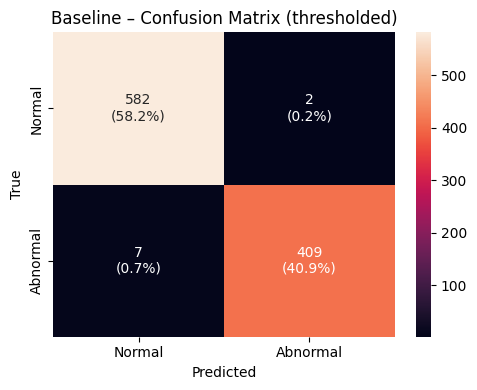


=== [Baseline – Test Results] ===
Loss:                  0.0350
Argmax Accuracy:       99.10%
Accuracy @ τ:          99.10%
F1 @ τ:                0.9891
ROC–AUC:               0.9981
PR–AUC:                0.9982

Sensitivity (Recall+): 0.983
Specificity (Recall–): 0.997
PPV (Precision+):      0.995
NPV (Precision–):      0.988
Balanced Accuracy:     0.990


In [14]:
# === Baseline — Calibration -> Threshold (F1 on validation) -> Test evaluation (full report) ===
crit = nn.BCEWithLogitsLoss()

# 1) Calibrate on validation (Temperature Scaling)
T_base = learn_temperature_Base(baseline, val_loader)

# 2) Choose threshold by F1 on validation (using calibrated probs)
_, _, _, yv_base, pv_base = evaluate_model_Base(baseline, val_loader, crit, temperature=T_base)
th_base, f1_val_base, p_val_base, r_val_base = select_threshold_by_fbeta_Base(yv_base, pv_base, beta=1.0)
print("\n=== [Baseline – Validation Results] ===")
print(f"Threshold (T):         {T_base:.3f}")
print(f"Tau:                   {th_base:.3f}")
print(f"F1:                    {f1_val_base:.4f}")
print(f"Precision (P):         {p_val_base:.3f}")
print(f"Recall (R):            {r_val_base:.3f}")
print("="*38)
print("\n")

# 3) Evaluate on TEST using the chosen threshold (fixed from validation)
tl, ta_argmax, y_pred_argmax, y_true, y_prob = evaluate_model_Base(baseline, test_loader, crit, temperature=T_base)
y_pred = (y_prob >= th_base).astype(int)

# Core metrics (thresholded vs. threshold-free)
acc_b = accuracy_score(y_true, y_pred)               # thresholded
f1_b  = f1_score(y_true, y_pred)                     # thresholded
roc_b = roc_auc_score(y_true, y_prob)                # threshold-free
pr_b  = average_precision_score(y_true, y_prob)      # threshold-free

# Operating characteristics from the thresholded confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]

def safe_div(a, b):
    """Safe division returning NaN when denominator is zero."""
    return (a / b) if b > 0 else float('nan')

sensitivity = safe_div(TP, TP + FN)  # Recall(+)
specificity = safe_div(TN, TN + FP)
ppv = safe_div(TP, TP + FP)          # Precision
npv = safe_div(TN, TN + FN)
balanced_acc = np.nanmean([sensitivity, specificity])


# Single Confusion Matrix: counts + percent of total in each cell
plot_cm_counts_percent(
    cm, total=len(y_true), labels=('Normal','Abnormal'),
    title='Baseline – Confusion Matrix (thresholded)'
)

# Report
print("\n=== [Baseline – Test Results] ===")
print(f"Loss:                  {tl:.4f}")
print(f"Argmax Accuracy:       {ta_argmax:.2f}%")
print(f"Accuracy @ τ:          {acc_b*100:.2f}%")
print(f"F1 @ τ:                {f1_b:.4f}")
print(f"ROC–AUC:               {roc_b:.4f}")
print(f"PR–AUC:                {pr_b:.4f}")
print()
print(f"Sensitivity (Recall+): {sensitivity:.3f}")
print(f"Specificity (Recall–): {specificity:.3f}")
print(f"PPV (Precision+):      {ppv:.3f}")
print(f"NPV (Precision–):      {npv:.3f}")
print(f"Balanced Accuracy:     {balanced_acc:.3f}")
print("="*34)

# Keep for summary (existing variables preserved)
test_acc_b = acc_b * 100.0
test_f1_b  = f1_b
test_roc_b = roc_b
test_pr_b  = pr_b
test_sens_b = sensitivity
test_spec_b = specificity
test_ppv_b  = ppv
test_npv_b  = npv
test_balacc_b = balanced_acc

#Enhanced Features - Moving Average + Derivative

In [15]:
# ================== Enhanced Features (3ch: raw_z, MA_z, HP_z) ==================
def make_enhanced_features_psz(X_raw: np.ndarray, window: int = 5,
                               eps: float = 1e-6, clip: float | None = 6.0) -> np.ndarray:
    """Build 3 stable per-sample channels from raw ECG.

    Channels:
        ch0 (raw_z): Per-sample Z-score of the raw signal.
        ch1 (MA_z):  Moving average of raw_z with a window of length ``window``.
        ch2 (HP_z):  High-pass residual = raw_z - MA_z (smooth, avoids sharp derivative).

    Notes:
        - Operates independently per sample—no fitting, no leakage across splits.
        - Output is already per-sample standardized; no second Z-score needed.
        - ``window`` should be >= 1; using an odd window often preserves phase better,
          but even values are supported (via 'same' convolution).

    Args:
        X_raw: Array of shape (N, L) with raw sequences.
        window: Moving-average window length (>= 1).
        eps: Small constant used inside ``zscore_per_sample`` to avoid division by zero.
        clip: Optional clipping bound applied inside ``zscore_per_sample``.

    Returns:
        feats: Float32 array of shape (N, L, 3) with (raw_z, MA_z, HP_z).
    """
    X_raw = np.asarray(X_raw, dtype=np.float64)          # (N, L)
    raw_z = zscore_per_sample(X_raw, eps=eps, clip=clip) # (N, L) float32

    # Moving average on normalized signal (raw_z)
    kernel = np.ones(window, dtype=np.float32) / float(window)
    # np.convolve runs per-sample; keep float32 for consistency/perf
    ma_z = np.stack([np.convolve(seq.astype(np.float32), kernel, mode='same')
                     for seq in raw_z.astype(np.float32)], axis=0)            # (N, L) float32

    # High-pass stable: raw_z - MA_z
    hp_z = raw_z.astype(np.float32) - ma_z                                     # (N, L) float32

    feats = np.stack([raw_z.astype(np.float32), ma_z, hp_z], axis=-1)          # (N, L, 3)
    return feats  # Already per-sample standardized; no second Z-score required.

# --- Build 3-channel datasets (no global scaler) ---
Xtr_enh  = make_enhanced_features_psz(X_tr_raw,  window=5)
Xval_enh = make_enhanced_features_psz(X_val_raw, window=5)
Xte_enh  = make_enhanced_features_psz(X_te_raw,  window=5)

# --- DataLoaders for enhanced/ultimate (channels=3) ---
train_loader_enh, val_loader_enh, test_loader_enh = make_loaders(
    Xtr_enh, y_tr, Xval_enh, y_val, Xte_enh, y_te, batch_size=64, channels=3
)


# Dual-Branch Transformer–TCN (Gated Fusion)




####A hybrid 1D model that processes the ECG sequence through two parallel branches - a Transformer (for global, long-range dependencies) and a Temporal Convolutional Network (TCN) (for local morphology with dilations). Each branch turns the full beat into a single feature vector via attention pooling - a learned softmax gate then blends the two vectors per feature, and a small MLP classifier produces the logits.


In [16]:
# ================== Enhanced Model: Transformer + TCN (parallel) ==================
class AttnPool1D(nn.Module):
    """Attention pooling over the time axis.

    Takes a sequence of tokens and produces a single vector via learned
    per-timestep scores followed by a softmax-weighted average.

    Args:
        d_model: Hidden dimension D.
        dropout: Dropout probability applied to the pooled output.

    Shapes:
        x: (B, L, D)  ->  out: (B, D)
    """
    def __init__(self, d_model: int, dropout: float = 0.1):
        super().__init__()
        self.scorer = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Linear(d_model, 1)
        )
        self.drop = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # x: (B,L,D)
        scores = self.scorer(x).squeeze(-1)              # (B,L)
        scores = scores - scores.max(dim=1, keepdim=True).values
        alpha  = F.softmax(scores, dim=1)                # (B,L)
        out = (alpha.unsqueeze(-1) * x).sum(dim=1)  # (B,D)
        return self.drop(out)


class TCNBlock(nn.Module):
    """Residual TCN block with dilated Conv1d + LayerNorm + GELU + Dropout.

    Args:
        channels: Number of channels (C) for input/output of the block.
        kernel_size: Temporal kernel size (prefer odd to preserve length).
        dilation: Dilation factor for the convolution.
        dropout: Dropout probability.

    Shapes:
        x: (B, C, L)  ->  out: (B, C, L)
    """
    def __init__(self, channels: int, kernel_size: int, dilation: int, dropout: float = 0.1):
        super().__init__()
        padding = ((kernel_size - 1) // 2) * dilation  # 'same' length along time
        self.conv = nn.Conv1d(channels, channels, kernel_size=kernel_size,
                              padding=padding, dilation=dilation)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(channels)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # x: (B,C,L)
        residual = x
        y = self.conv(x)                 # (B,C,L)
        y = y.transpose(1, 2)            # -> (B, L, C) for LayerNorm over channel dim
        y = self.ln(y)
        y = self.act(y)
        y = y.transpose(1, 2)            # -> (B,C,L)
        y = self.dropout(y)
        return y + residual              # residual connection

class TCNBranch(nn.Module):
    """Hierarchical TCN branch: stem → dilated blocks → 1×1 projection → attention pooling.

    Produces a single vector of size ``d_out``.

    Args:
        in_ch:   Input channels C_in.
        hidden:  Hidden channels inside TCN blocks.
        depth:   Number of residual TCN blocks (with exponential dilations).
        kernel_size: Temporal kernel size in stem/blocks.
        dropout: Dropout probability in blocks and pooling.
        d_out:   Output feature dimension D for this branch.

    Shapes:
        x: (B, L, C_in)  ->  out: (B, d_out)
    """
    def __init__(self, in_ch: int = 3, hidden: int = 64, depth: int = 4,
                 kernel_size: int = 7, dropout: float = 0.1, d_out: int = 128):
        super().__init__()
        self.stem = nn.Conv1d(in_ch, hidden, kernel_size=kernel_size,
                              padding=kernel_size // 2)
        blocks = []
        for i in range(depth):
            blocks.append(TCNBlock(hidden, kernel_size=kernel_size,
                                   dilation=(2 ** i), dropout=dropout))
        self.blocks = nn.Sequential(*blocks)
        self.proj = nn.Conv1d(hidden, d_out, kernel_size=1)
        self.pool = AttnPool1D(d_out, dropout=dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # x: (B,L,C)
        x = x.permute(0, 2, 1)        # -> (B,C,L)
        x = self.stem(x)              # (B,H,L)
        x = self.blocks(x)            # (B,H,L)
        x = self.proj(x)              # (B,D,L)
        x = x.permute(0, 2, 1)        # -> (B,L,D)
        x = self.pool(x)              # (B,D)
        return x


class TransformerBranch(nn.Module):
    """Transformer branch: Conv1d stem → LN+GELU → PositionalEncoding → Encoder → AttnPooling.

    Produces a single vector of size ``d_model``.

    Args:
        in_ch: Input channels C_in.
        d_model: Transformer hidden dimension D.
        nhead: Number of attention heads.
        layers: Number of Transformer encoder layers.
        dropout: Dropout probability in encoder and pooling.
        kernel_size: Temporal kernel size for the Conv1d stem.

    Shapes:
        x: (B, L, C_in)  ->  out: (B, d_model)
    """
    def __init__(self, in_ch: int = 3, d_model: int = 128, nhead: int = 8,
                 layers: int = 3, dropout: float = 0.1, kernel_size: int = 7):
        super().__init__()
        # Conv1d stem (stride=1, padding='same' via ks//2)
        self.stem_conv = nn.Conv1d(in_ch, d_model, kernel_size=kernel_size,
                                   padding=kernel_size // 2)
        self.stem_ln   = nn.LayerNorm(d_model)  # applied after returning to (B, L, D)
        self.stem_act  = nn.GELU()

        self.pos = PositionalEncoding(d_model)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model * 4,
            dropout=dropout, activation='gelu', batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=layers)
        self.pool = AttnPool1D(d_model, dropout=dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # x: (B,L,C)
        # Conv1d stem
        x = x.permute(0, 2, 1)          # -> (B,C,L)
        x = self.stem_conv(x)           # (B,D,L)
        x = x.permute(0, 2, 1)          # -> (B,L,D)
        x = self.stem_ln(x)
        x = self.stem_act(x)

        # Positional encoding + Transformer
        x = self.pos(x)                 # (B,L,D)
        x = self.encoder(x)             # (B,L,D)

        # Attention pooling through time
        x = self.pool(x)                # (B,D)
        return x


class TransformerPlusTCN(nn.Module):
    """Enhanced model: parallel Transformer and TCN branches with softmax-gated fusion.

    The name is kept for backward compatibility with existing code.

    Args:
        in_ch: Input channels C_in.
        d_model: Shared feature dimension D across branches.
        nhead: Number of attention heads in the Transformer branch.
        layers: Number of Transformer encoder layers.
        num_classes: Number of output classes.
        dropout: Dropout probability used across modules.
        tcn_depth: Number of TCN residual blocks (with dilations 1,2,4,...).
        kernel_size: Temporal kernel size for stems/blocks.

    Shapes:
        x: (B, L, C_in)  ->  logits: (B, num_classes)
    """
    def __init__(self, in_ch: int = 3, d_model: int = 128, nhead: int = 8,
                 layers: int = 3, num_classes: int = 2, dropout: float = 0.1,
                 tcn_depth: int = 4, kernel_size: int = 7):
        super().__init__()

        # --- Parallel branches ---
        self.tcn   = TCNBranch(in_ch=in_ch, hidden=64, depth=tcn_depth,
                               kernel_size=kernel_size, dropout=dropout, d_out=d_model)
        self.trans = TransformerBranch(in_ch=in_ch, d_model=d_model, nhead=nhead,
                                       layers=layers, dropout=dropout, kernel_size=kernel_size)

         # --- Normalization before fusion (helps balance branch scales) ---
        self.ln_tcn   = nn.LayerNorm(d_model)
        self.ln_trans = nn.LayerNorm(d_model)

        # --- Softmax Gated fusion ---
        # Small MLP returns 2*D scores (per-branch per-feature), then softmax across branches.
        self.gate_fc1 = nn.Linear(2 * d_model, d_model)
        self.gate_act = nn.GELU()
        self.gate_fc2 = nn.Linear(d_model, 2 * d_model)  # יאתחל לנייטרלי (0 → softmax → 0.5/0.5)
        self.gate = nn.Sequential(self.gate_fc1, self.gate_act, self.gate_fc2)

        # Neutral init so the gate starts near equal weighting of branches
        nn.init.zeros_(self.gate_fc2.weight)
        nn.init.zeros_(self.gate_fc2.bias)

        # --- Classification Head ---
        self.cls = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # x: (B, L, C)
        v_tcn   = self.tcn(x)         # (B, D)
        v_trans = self.trans(x)       # (B, D)

        # Normalize before gating
        v_tcn_n   = self.ln_tcn(v_tcn)       # (B, D)
        v_trans_n = self.ln_trans(v_trans)   # (B, D)

        # Gate scores for the two branches per feature: (B, 2, D)
        z = torch.cat([v_trans_n, v_tcn_n], dim=1)   # (B, 2D)
        scores = self.gate(z).view(z.size(0), 2, -1) # (B, 2, D)
        scores = scores - scores.max(dim=1, keepdim=True).values

        # Softmax over the branch axis (weights sum to 1 per feature)
        alpha = F.softmax(scores, dim=1)             # (B, 2, D)
        g_trans = alpha[:, 0, :]                     # (B, D)
        g_tcn   = alpha[:, 1, :]                     # (B, D)

        # Per-feature convex fusion of branch vectors
        fused = g_trans * v_trans + g_tcn * v_tcn    # (B, D)

        logits = self.cls(fused)                     # (B, num_classes)
        return logits


#Train Enhanced - Dual-Branch

In [17]:
# ====================== Train ======================
enhanced = TransformerPlusTCN(in_ch=3, d_model=128, nhead=8, layers=3, num_classes=2, dropout=0.1)

# Note: `fit` selects by PR-AUC and returns (history, best_pr_auc, best_epoch)
hist_enh, best_acc_enh, best_epoch_enh = fit(enhanced, train_loader_enh, val_loader_enh, epochs=40)
print(f"Dual-Branch best val acc: {best_acc_enh:.2f}% at epoch {best_epoch_enh}")

# ====================== Evaluate Enhanced (calibration + F1 threshold) ======================
crit_enh = nn.CrossEntropyLoss()

# 1) Calibrate on validation via temperature scaling (uncalibrated logits cached; optimize scalar T only)
T_enh = learn_temperature(enhanced, val_loader_enh)

# 2) Choose decision threshold tau by maximizing F1 on validation using calibrated probabilities
_, _, _, yv_enh, pv_enh = evaluate_model(enhanced, val_loader_enh, crit_enh, temperature=T_enh)
th_enh, f1_val_enh, p_val_enh, r_val_enh = select_threshold_by_fbeta(yv_enh, pv_enh, beta=1.0)
print("\n=== [Dual-Branch – Validation Results] ===")
print(f"Threshold (T):         {T_base:.3f}")
print(f"Tau:                   {th_base:.3f}")
print(f"F1:                    {f1_val_base:.4f}")
print(f"Precision (P):         {p_val_base:.3f}")
print(f"Recall (R):            {r_val_base:.3f}")
print("="*38)
print("\n")


Epoch 001 | lr 2.50e-04 | train loss 0.3045 acc 88.83% | val loss 0.0902 acc 97.00% | PR-AUC 0.9915 ROC-AUC 0.9906
Epoch 002 | lr 5.00e-04 | train loss 0.0565 acc 98.27% | val loss 0.1056 acc 96.10% | PR-AUC 0.9984 ROC-AUC 0.9985
Epoch 003 | lr 7.50e-04 | train loss 0.0309 acc 99.03% | val loss 0.0540 acc 98.20% | PR-AUC 0.9979 ROC-AUC 0.9978
Epoch 004 | lr 1.00e-03 | train loss 0.0359 acc 99.00% | val loss 0.0346 acc 99.10% | PR-AUC 0.9983 ROC-AUC 0.9977
Epoch 005 | lr 1.00e-03 | train loss 0.0261 acc 99.17% | val loss 0.0391 acc 98.80% | PR-AUC 0.9984 ROC-AUC 0.9985
Epoch 006 | lr 9.98e-04 | train loss 0.0227 acc 99.53% | val loss 0.0484 acc 98.70% | PR-AUC 0.9986 ROC-AUC 0.9985
Epoch 007 | lr 9.93e-04 | train loss 0.0287 acc 99.30% | val loss 0.0349 acc 99.40% | PR-AUC 0.9988 ROC-AUC 0.9988
Epoch 008 | lr 9.85e-04 | train loss 0.0206 acc 99.37% | val loss 0.0385 acc 99.10% | PR-AUC 0.9978 ROC-AUC 0.9977
Epoch 009 | lr 9.73e-04 | train loss 0.0183 acc 99.53% | val loss 0.0420 acc 98.

#Evaluate Enhanced - Dual-Branch


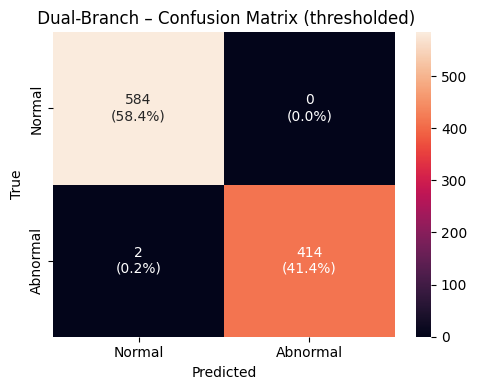


=== [Dual-Branch – Test Results] ===
Loss:                  0.0217
Argmax Accuracy:       99.50%
Accuracy @ τ:          99.10%
F1 @ τ:                0.9891
ROC–AUC:               0.9981
PR–AUC:                0.9982

Sensitivity (Recall+): 0.983
Specificity (Recall–): 0.997
PPV (Precision+):      0.995
NPV (Precision–):      0.988
Balanced Accuracy:     0.990


In [18]:
# ====================== Enhanced — Test evaluation (full report) ======================
# Evaluate on TEST using the chosen temperature & threshold from validation
tl, ta_argmax, y_pred_argmax, y_true_enh, y_prob_enh = evaluate_model(
    enhanced, test_loader_enh, crit_enh, temperature=T_enh
)
y_pred_enh = (y_prob_enh >= th_enh).astype(int)

# Core metrics (thresholded vs. threshold-free)
acc_enh = accuracy_score(y_true_enh, y_pred_enh)          # thresholded
f1_enh  = f1_score(y_true_enh, y_pred_enh)                # thresholded
roc_enh = roc_auc_score(y_true_enh, y_prob_enh)           # threshold-free
pr_enh  = average_precision_score(y_true_enh, y_prob_enh) # threshold-free

# Operating characteristics from the thresholded confusion matrix
cm_enh = confusion_matrix(y_true_enh, y_pred_enh, labels=[0, 1])
TN, FP, FN, TP = cm_enh[0, 0], cm_enh[0, 1], cm_enh[1, 0], cm_enh[1, 1]

def safe_div(a, b):
    """Safe division that returns NaN when denominator is zero."""
    return (a / b) if b > 0 else float('nan')

sensitivity_enh = safe_div(TP, TP + FN)  # Recall(+)
specificity_enh = safe_div(TN, TN + FP)
ppv_enh = safe_div(TP, TP + FP)          # Precision
npv_enh = safe_div(TN, TN + FN)
balanced_acc_enh = np.nanmean([sensitivity_enh, specificity_enh])



# Single Confusion Matrix: counts + percent of total in each cell
plot_cm_counts_percent(
    cm_enh, total=len(y_true_enh), labels=('Normal','Abnormal'),
    title=' Dual-Branch – Confusion Matrix (thresholded)'
)

# Report
print("\n=== [Dual-Branch – Test Results] ===")
print(f"Loss:                  {tl:.4f}")
print(f"Argmax Accuracy:       {ta_argmax:.2f}%")
print(f"Accuracy @ τ:          {acc_b*100:.2f}%")
print(f"F1 @ τ:                {f1_b:.4f}")
print(f"ROC–AUC:               {roc_b:.4f}")
print(f"PR–AUC:                {pr_b:.4f}")
print()
print(f"Sensitivity (Recall+): {sensitivity:.3f}")
print(f"Specificity (Recall–): {specificity:.3f}")
print(f"PPV (Precision+):      {ppv:.3f}")
print(f"NPV (Precision–):      {npv:.3f}")
print(f"Balanced Accuracy:     {balanced_acc:.3f}")
print("="*34)

# Keep for summary
test_acc_enh     = acc_enh * 100.0
test_f1_enh      = f1_enh
test_roc_enh     = roc_enh
test_pr_enh      = pr_enh
test_sens_enh    = sensitivity_enh
test_spec_enh    = specificity_enh
test_ppv_enh     = ppv_enh
test_npv_enh     = npv_enh
test_balacc_enh  = balanced_acc_enh

# Tri-Branch Transformer–TCN–BiLSTM (Gated Fusion)

####Similar to the Enhanced model, but with BiLSTM in parallel to the transformer and TCN.

In [19]:
class BiLSTMBranch(nn.Module):
    """BiLSTM branch:
    Linear(in_ch → hidden) → BiLSTM (bidirectional) → Linear(2*hidden → out_dim) → AttnPool1D(out_dim).

    Returns a vector of size ``out_dim`` (typically ``out_dim == d_model``).

    Args:
        in_ch:  Input channels C.
        hidden: Hidden size H of the LSTM (per direction).
        layers: Number of stacked LSTM layers.
        dropout: Dropout after the output projection and inside attention pooling.
                 (Note: LSTM's internal ``dropout`` is effective only when ``layers > 1``.)
        out_dim: Output feature dimension for this branch.

    Shapes:
        x: (B, L, C) → out: (B, out_dim)
    """
    def __init__(self, in_ch: int = 3, hidden: int = 64, layers: int = 1,
                 dropout: float = 0.1, out_dim: int = 128):
        super().__init__()
        self.proj_in = nn.Linear(in_ch, hidden)
        self.lstm = nn.LSTM(hidden, hidden, num_layers=layers,
                            batch_first=True, bidirectional=True, dropout=0.0)   # LSTM dropout is applied only if layers > 1; we keep 0.0 here.
        # Ensure a consistent final dimensionality across branches
        self.proj_out = nn.Linear(2 * hidden, out_dim)
        self.drop = nn.Dropout(dropout)
        self.pool = AttnPool1D(out_dim, dropout=dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:   # x: (B, L, C)
        x = self.proj_in(x)                 # (B, L, H)
        y, _ = self.lstm(x)                 # (B, L, 2H)
        y = self.proj_out(y)                # (B, L, out_dim)
        y = self.drop(y)
        y = self.pool(y)                    # (B, out_dim)
        return y


class TransformerTCNBiLSTM(nn.Module):
    """Ultimate model: three parallel branches (TCN + Transformer + BiLSTM) with
    softmax-gated tri-branch fusion and a shared classification head.

    Args:
        in_ch: Input channels C_in.
        d_model: Shared feature dimension D across branches.
        nhead: Number of attention heads in the Transformer branch.
        t_layers: Number of Transformer encoder layers in the Transformer branch.
        lstm_hidden: Hidden size for the BiLSTM branch (per direction).
        num_classes: Number of output classes.
        dropout: Dropout probability across modules.
        tcn_depth: Number of residual TCN blocks (with dilations 1, 2, 4, ...).
        kernel_size: Temporal kernel size for stems/blocks.

    Shapes:
        x: (B, L, C_in) → logits: (B, num_classes)
    """
    def __init__(self, in_ch: int = 3, d_model: int = 128, nhead: int = 8,
                 t_layers: int = 3, lstm_hidden: int = 64, num_classes: int = 2,
                 dropout: float = 0.1, tcn_depth: int = 4, kernel_size: int = 7):
        super().__init__()
        # --- Parallel branches ---
        self.tcn = TCNBranch(
            in_ch=in_ch, hidden=64, depth=tcn_depth,
            kernel_size=kernel_size, dropout=dropout, d_out=d_model
        )
        self.trans = TransformerBranch(
            in_ch=in_ch, d_model=d_model, nhead=nhead,
            layers=t_layers, dropout=dropout, kernel_size=kernel_size
        )
        self.lstm = BiLSTMBranch(
            in_ch=in_ch, hidden=lstm_hidden, layers=1,
            dropout=dropout, out_dim=d_model
        )

        # --- Normalization before fusion (stabilizes inter-branch scales) ---
        self.ln_tcn   = nn.LayerNorm(d_model)
        self.ln_trans = nn.LayerNorm(d_model)
        self.ln_lstm  = nn.LayerNorm(d_model)

        # --- Softmax-gated fusion (3 branches) ---
        # Gate: Linear(3D → D) → GELU → Linear(D → 3D) → reshape (B, 3, D) → softmax over branch axis
        self.gate_fc1 = nn.Linear(3 * d_model, d_model)
        self.gate_act = nn.GELU()
        self.gate_fc2 = nn.Linear(d_model, 3 * d_model)

        # Neutral init: start near one-third for each branch
        nn.init.zeros_(self.gate_fc2.weight)
        nn.init.zeros_(self.gate_fc2.bias)

        # --- Classification head ---
        self.cls = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:    # x: (B, L, C=3)
        v_tcn   = self.tcn(x)          # (B, D)
        v_trans = self.trans(x)        # (B, D)
        v_lstm  = self.lstm(x)         # (B, D)

        # LayerNorm before gating
        v_tcn_n   = self.ln_tcn(v_tcn)       # (B, D)
        v_trans_n = self.ln_trans(v_trans)   # (B, D)
        v_lstm_n  = self.ln_lstm(v_lstm)     # (B, D)

        # Gate scores for the three branches per feature: (B, 3, D)
        z = torch.cat([v_trans_n, v_tcn_n, v_lstm_n], dim=1)     # (B, 3D)
        scores = self.gate_fc2(self.gate_act(self.gate_fc1(z)))  # (B, 3D)
        scores = scores.view(z.size(0), 3, -1)                   # (B, 3, D)
        scores = scores - scores.max(dim=1, keepdim=True).values

        # Softmax over branches (weights sum to 1 per feature)
        alpha = F.softmax(scores, dim=1)                         # (B,3,D)
        a_trans, a_tcn, a_lstm = alpha[:, 0, :], alpha[:, 1, :], alpha[:, 2, :]  # (B,D) כל אחד

        # Convex fusion
        fused = a_trans * v_trans + a_tcn * v_tcn + a_lstm * v_lstm  # (B,D)

        # Classification head
        logits = self.cls(fused)                                    # (B,num_classes)
        return logits


# Alias kept for backward compatibility with existing code:
TransformerCNNBiLSTM = TransformerTCNBiLSTM


#Train Tri-Branch

In [20]:
# ====================== Train Ultimate ======================
ultimate = TransformerTCNBiLSTM(in_ch=3, d_model=128, nhead=8, t_layers=3,
                                lstm_hidden=64, num_classes=2, dropout=0.1)
hist_ult, best_pr_auc_ult, best_epoch_ult = fit(ultimate, train_loader_enh, val_loader_enh, epochs=40)
print(f"Tri-Branch best val PR-AUC: {best_pr_auc_ult:.4f} at epoch {best_epoch_ult}")

# ====================== Evaluate Ultimate (calibration + F1 threshold) ======================
crit_ult = nn.CrossEntropyLoss()

# 1) Calibrate on validation (Temperature Scaling; optimize scalar T over cached logits)
T_ult = learn_temperature(ultimate, val_loader_enh)

# 2) Choose threshold by F1 on validation (using calibrated probabilities)
_, _, _, yv_ult, pv_ult = evaluate_model(ultimate, val_loader_enh, crit_ult, temperature=T_ult)
th_ult, f1_val_ult, p_val_ult, r_val_ult = select_threshold_by_fbeta(yv_ult, pv_ult, beta=1.0)
print("\n=== [Tri-Branch – Validation Results] ===")
print(f"Threshold (T):         {T_base:.3f}")
print(f"Tau:                   {th_base:.3f}")
print(f"F1:                    {f1_val_base:.4f}")
print(f"Precision (P):         {p_val_base:.3f}")
print(f"Recall (R):            {r_val_base:.3f}")
print("="*38)
print("\n")

Epoch 001 | lr 2.50e-04 | train loss 0.3217 acc 89.07% | val loss 0.0800 acc 97.80% | PR-AUC 0.9937 ROC-AUC 0.9941
Epoch 002 | lr 5.00e-04 | train loss 0.0512 acc 98.60% | val loss 0.0548 acc 98.30% | PR-AUC 0.9975 ROC-AUC 0.9975
Epoch 003 | lr 7.50e-04 | train loss 0.0492 acc 98.53% | val loss 0.0428 acc 98.60% | PR-AUC 0.9981 ROC-AUC 0.9981
Epoch 004 | lr 1.00e-03 | train loss 0.0400 acc 98.87% | val loss 0.0523 acc 98.00% | PR-AUC 0.9980 ROC-AUC 0.9972
Epoch 005 | lr 1.00e-03 | train loss 0.0251 acc 99.40% | val loss 0.0332 acc 99.00% | PR-AUC 0.9979 ROC-AUC 0.9972
Epoch 006 | lr 9.98e-04 | train loss 0.0143 acc 99.53% | val loss 0.0415 acc 98.70% | PR-AUC 0.9984 ROC-AUC 0.9981
Epoch 007 | lr 9.93e-04 | train loss 0.0155 acc 99.53% | val loss 0.0375 acc 99.10% | PR-AUC 0.9959 ROC-AUC 0.9969
Epoch 008 | lr 9.85e-04 | train loss 0.0211 acc 99.53% | val loss 0.0417 acc 98.60% | PR-AUC 0.9982 ROC-AUC 0.9980
Epoch 009 | lr 9.73e-04 | train loss 0.0205 acc 99.53% | val loss 0.0365 acc 99.

#Evaluate Tri-Branch

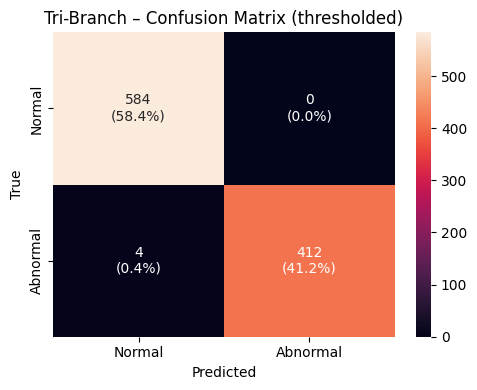


=== [Tri-Branch – Test Results] ===
Loss:                  0.0221
Argmax Accuracy:       99.40%
Accuracy @ τ:          99.10%
F1 @ τ:                0.9891
ROC–AUC:               0.9981
PR–AUC:                0.9982

Sensitivity (Recall+): 0.983
Specificity (Recall–): 0.997
PPV (Precision+):      0.995
NPV (Precision–):      0.988
Balanced Accuracy:     0.990


In [21]:
# ====================== Ultimate — Test evaluation (full report) ======================
# 3) Evaluate on TEST using the temperature & threshold chosen on validation
tl, ta_argmax, y_pred_argmax, y_true_ult, y_prob_ult = evaluate_model(
    ultimate, test_loader_enh, crit_ult, temperature=T_ult
)
y_pred_ult = (y_prob_ult >= th_ult).astype(int)

# Core metrics (thresholded vs. threshold-free)
acc_ult = accuracy_score(y_true_ult, y_pred_ult)          # thresholded
f1_ult  = f1_score(y_true_ult, y_pred_ult)                # thresholded
roc_ult = roc_auc_score(y_true_ult, y_prob_ult)           # threshold-free
pr_ult  = average_precision_score(y_true_ult, y_prob_ult) # threshold-free

# Operating characteristics from the thresholded confusion matrix
cm_ult = confusion_matrix(y_true_ult, y_pred_ult, labels=[0, 1])

def safe_div(a, b):
    """Safe division returning NaN when denominator is zero."""
    return (a / b) if b > 0 else float('nan')

TN, FP, FN, TP = cm_ult[0, 0], cm_ult[0, 1], cm_ult[1, 0], cm_ult[1, 1]
sensitivity_ult   = safe_div(TP, TP + FN)  # Recall(+)
specificity_ult   = safe_div(TN, TN + FP)
ppv_ult           = safe_div(TP, TP + FP)  # Precision
npv_ult           = safe_div(TN, TN + FN)
balanced_acc_ult  = np.nanmean([sensitivity_ult, specificity_ult])

# Single confusion matrix: counts + percent of total in each cell
plot_cm_counts_percent(
    cm_ult, total=len(y_true_ult), labels=('Normal','Abnormal'),
    title='Tri-Branch – Confusion Matrix (thresholded)'
)

# Report
print("\n=== [Tri-Branch – Test Results] ===")
print(f"Loss:                  {tl:.4f}")
print(f"Argmax Accuracy:       {ta_argmax:.2f}%")
print(f"Accuracy @ τ:          {acc_b*100:.2f}%")
print(f"F1 @ τ:                {f1_b:.4f}")
print(f"ROC–AUC:               {roc_b:.4f}")
print(f"PR–AUC:                {pr_b:.4f}")
print()
print(f"Sensitivity (Recall+): {sensitivity:.3f}")
print(f"Specificity (Recall–): {specificity:.3f}")
print(f"PPV (Precision+):      {ppv:.3f}")
print(f"NPV (Precision–):      {npv:.3f}")
print(f"Balanced Accuracy:     {balanced_acc:.3f}")
print("="*34)

# Keep for summary
test_acc_ult     = acc_ult * 100.0
test_f1_ult      = f1_ult
test_roc_ult     = roc_ult
test_pr_ult      = pr_ult
test_sens_ult    = sensitivity_ult
test_spec_ult    = specificity_ult
test_ppv_ult     = ppv_ult
test_npv_ult     = npv_ult
test_balacc_ult  = balanced_acc_ult


#Summary and Winner

In [24]:
# === Single-Run Summary (full metrics, calibrated @ tau from val) ===
summary = pd.DataFrame([
    {
        "Model":   "Baseline Transformer",
        "Acc(%)":  test_acc_b,     "F1":       test_f1_b,
        "ROC_AUC": test_roc_b,     "PR_AUC":   test_pr_b,
        "Sens":    test_sens_b,    "Spec":     test_spec_b,
        "PPV":     test_ppv_b,     "NPV":      test_npv_b,
        "BalAcc":  test_balacc_b,
    },
    {
        "Model":   "Dual-Branch",
        "Acc(%)":  test_acc_enh,   "F1":       test_f1_enh,
        "ROC_AUC": test_roc_enh,   "PR_AUC":   test_pr_enh,
        "Sens":    test_sens_enh,  "Spec":     test_spec_enh,
        "PPV":     test_ppv_enh,   "NPV":      test_npv_enh,
        "BalAcc":  test_balacc_enh,
    },
    {
        "Model":   "Tri-Branch",
        "Acc(%)":  test_acc_ult,   "F1":       test_f1_ult,
        "ROC_AUC": test_roc_ult,   "PR_AUC":   test_pr_ult,
        "Sens":    test_sens_ult,  "Spec":     test_spec_ult,
        "PPV":     test_ppv_ult,   "NPV":      test_npv_ult,
        "BalAcc":  test_balacc_ult,
    },
])

# Ranking policy: prioritize PR-AUC (threshold-free), then F1 (thresholded at tau),
# then ROC-AUC, and finally Balanced Accuracy.
rank_cols = ["PR_AUC", "F1", "ROC_AUC", "BalAcc"]
ranked = (
    summary
    .assign(**{c: summary[c].fillna(-1.0) for c in rank_cols})
    .sort_values(by=rank_cols, ascending=[False, False, False, False])
    .reset_index(drop=True)
)
# Pretty display (Jupyter)
display(
    ranked.style.format({
        "Acc(%)":"{:.2f}", "F1":"{:.4f}",
        "ROC_AUC":"{:.4f}", "PR_AUC":"{:.4f}",
        "Sens":"{:.3f}", "Spec":"{:.3f}",
        "PPV":"{:.3f}", "NPV":"{:.3f}",
        "BalAcc":"{:.3f}",
    })
)

# Print concise winner summary
w = ranked.iloc[0]
print("\n" + "="*50)
print(" Single-Run WINNER")
print("="*50)
print(f"Model:       {w['Model']}")
print(f"PR-AUC:      {w['PR_AUC']:.4f}")
print(f"F1:          {w['F1']:.4f}")
print(f"ROC-AUC:     {w['ROC_AUC']:.4f}")
print(f"Acc @ τ:     {w['Acc(%)']:.2f}%")
print(f"BalancedAcc: {w['BalAcc']:.3f}")
print(f"Sensitivity: {w['Sens']:.3f}")
print(f"Specificity: {w['Spec']:.3f}")
print(f"PPV:         {w['PPV']:.3f}")
print(f"NPV:         {w['NPV']:.3f}")
print("="*50 + "\n")


,Model,Acc(%),F1,ROC_AUC,PR_AUC,Sens,Spec,PPV,NPV,BalAcc
0,Tri-Branch,99.60,0.9952,0.9983,0.9988,0.990,1.000,1.000,0.993,0.995
1,Dual-Branch,99.80,0.9976,0.9978,0.9983,0.995,1.000,1.000,0.997,0.998
2,Baseline Transformer,99.10,0.9891,0.9981,0.9982,0.983,0.997,0.995,0.988,0.990



 Single-Run WINNER
Model:       Tri-Branch
PR-AUC:      0.9988
F1:          0.9952
ROC-AUC:     0.9983
Acc @ τ:     99.60%
BalancedAcc: 0.995
Sensitivity: 0.990
Specificity: 1.000
PPV:         1.000
NPV:         0.993



#Train/Validation graphs

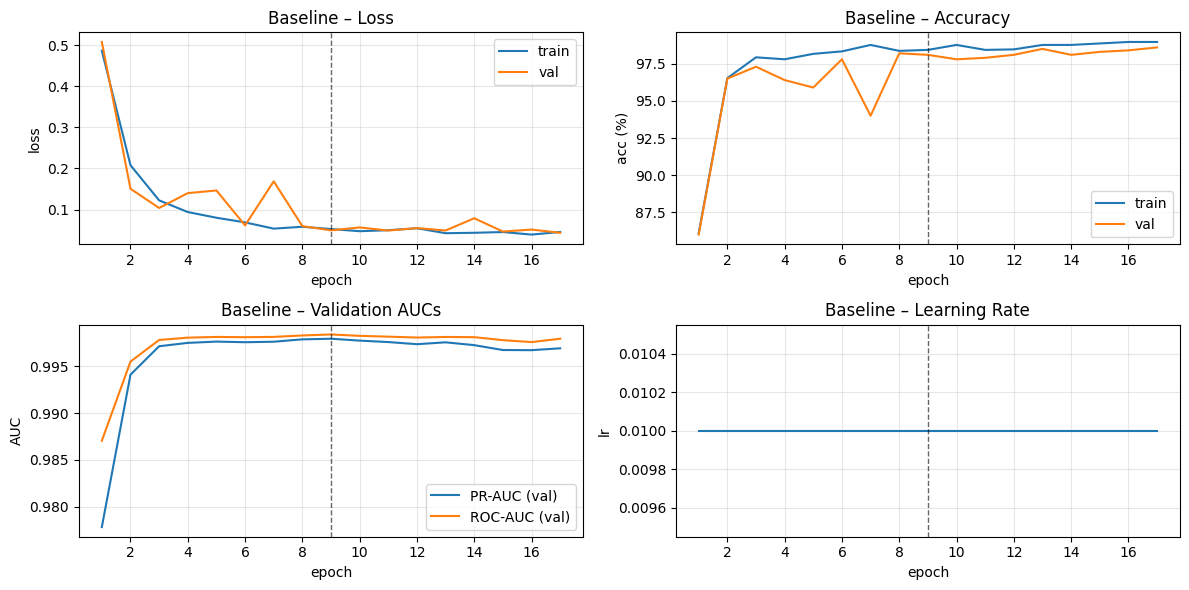

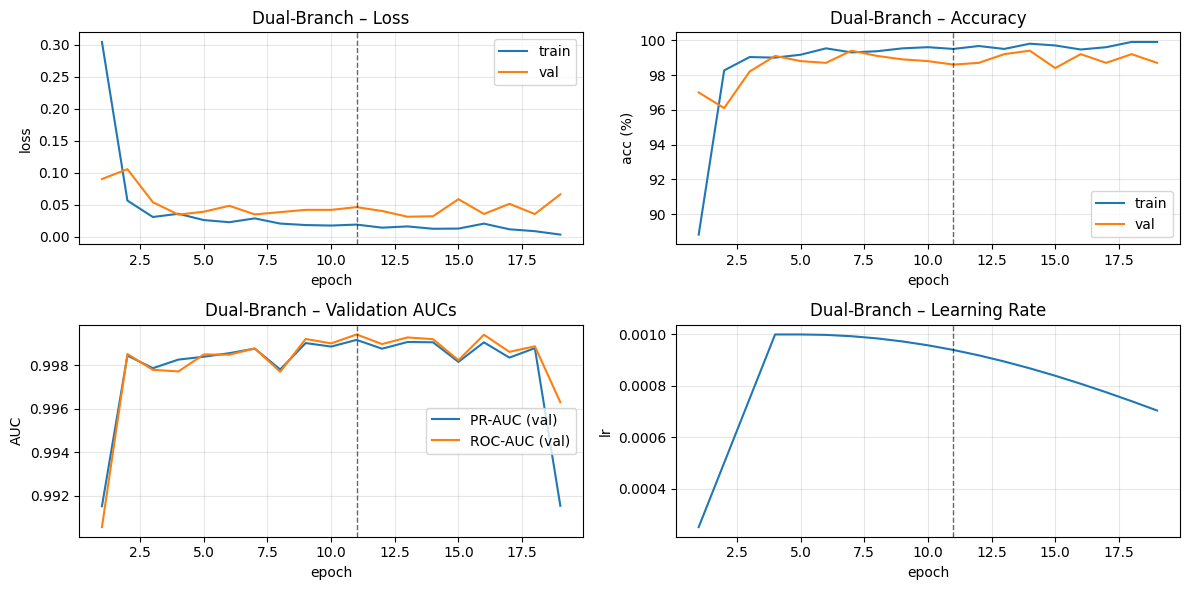

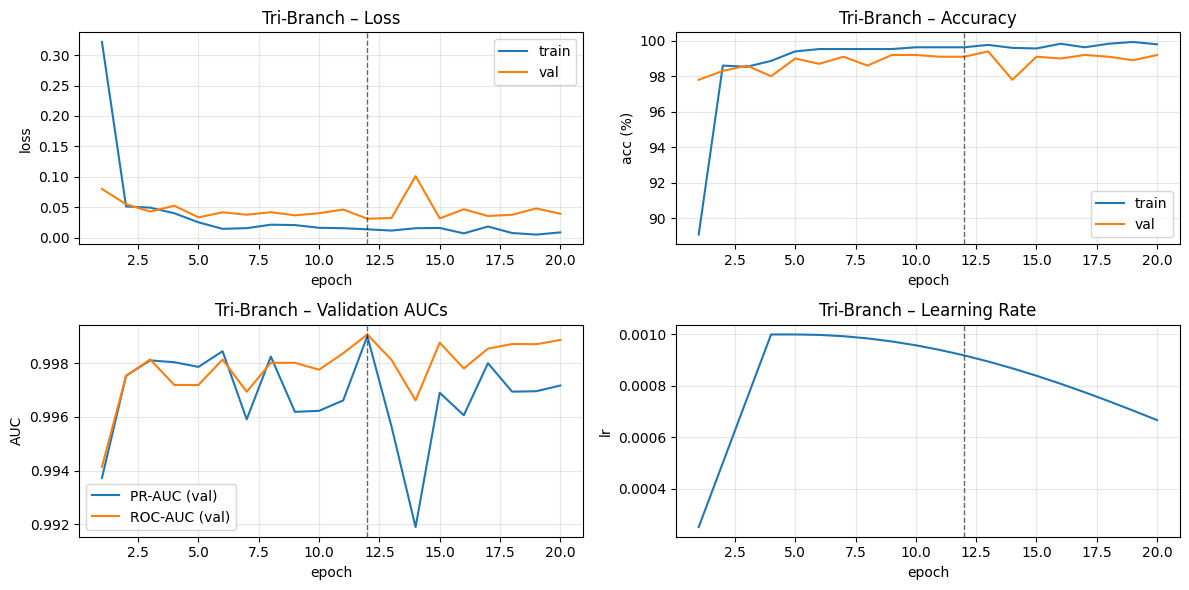

In [23]:
# ========== Train/Validation Graphs (loss/acc + PR-AUC/ROC-AUC + LR) ==========
def plot_curves(hist, title, best_epoch=None):
    """Plot training/validation curves.

    Panels (2x2):
      (1,1) Loss:     train_loss vs. val_loss
      (1,2) Accuracy: train_acc  vs. val_acc   (assumed in %)
      (2,1) AUCs:     val_pr_auc and/or val_roc_auc
      (2,2) LR:       learning rate per epoch (if provided)

    Args:
        hist: History dict as returned by `fit`, may include:
              'train_loss', 'val_loss', 'train_acc', 'val_acc',
              'val_pr_auc', 'val_roc_auc', 'lr'.
              Missing keys are handled gracefully.
        title: Figure title prefix (e.g., 'Baseline', 'Enhanced', 'Ultimate').
        best_epoch: If provided (>0), draw a vertical dashed line at this epoch.

    Notes:
        - Curves are drawn only for the series that exist in `hist`.
        - Accuracy is assumed to be already in percentage.
    """

    # Extract series if present
    tr_loss = hist.get('train_loss', [])
    va_loss = hist.get('val_loss',   [])
    tr_acc  = hist.get('train_acc',  [])
    va_acc  = hist.get('val_acc',    [])
    va_pr   = hist.get('val_pr_auc', [])
    va_roc  = hist.get('val_roc_auc',[])
    lrs     = hist.get('lr',         [])

    # Number of epochs from the longest available series
    T = max(len(tr_loss), len(va_loss), len(tr_acc), len(va_acc), len(va_pr), len(va_roc), len(lrs))
    epochs = list(range(1, T+1))

    # Prepare 2x2 layout
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    ax11, ax12, ax21, ax22 = axes[0,0], axes[0,1], axes[1,0], axes[1,1]

    # --- Panel (1,1): Loss ---
    if tr_loss: ax11.plot(range(1, len(tr_loss)+1), tr_loss, label='train')
    if va_loss: ax11.plot(range(1, len(va_loss)+1), va_loss, label='val')
    ax11.set_title(f'{title} – Loss'); ax11.set_xlabel('epoch'); ax11.set_ylabel('loss')
    ax11.legend(loc='best'); ax11.grid(True, alpha=0.3)

    # --- Panel (1,2): Accuracy ---
    if tr_acc: ax12.plot(range(1, len(tr_acc)+1), tr_acc, label='train')
    if va_acc: ax12.plot(range(1, len(va_acc)+1), va_acc, label='val')
    ax12.set_title(f'{title} – Accuracy'); ax12.set_xlabel('epoch'); ax12.set_ylabel('acc (%)')
    ax12.legend(loc='best'); ax12.grid(True, alpha=0.3)

    # --- Panel (2,1): Validation PR-AUC / ROC-AUC ---
    has_any_auc = False
    if va_pr:
        ax21.plot(range(1, len(va_pr)+1), va_pr, label='PR-AUC (val)')
        has_any_auc = True
    if va_roc:
        ax21.plot(range(1, len(va_roc)+1), va_roc, label='ROC-AUC (val)')
        has_any_auc = True
    ax21.set_title(f'{title} – Validation AUCs'); ax21.set_xlabel('epoch'); ax21.set_ylabel('AUC')
    if has_any_auc: ax21.legend(loc='best')
    ax21.grid(True, alpha=0.3)

    # --- Panel (2,2): Learning Rate (if present) ---
    if lrs:
        ax22.plot(range(1, len(lrs)+1), lrs, label='lr')
        ax22.set_title(f'{title} – Learning Rate'); ax22.set_xlabel('epoch'); ax22.set_ylabel('lr')
        ax22.grid(True, alpha=0.3)
    else:
        ax22.axis('off')  # no LR in history

   # Vertical line at the best epoch (if supplied)
    if isinstance(best_epoch, (int, float)) and best_epoch is not None and best_epoch > 0:
        for ax in (ax11, ax12, ax21, ax22):
            try:
                ax.axvline(best_epoch, color='k', linestyle='--', linewidth=1, alpha=0.6)
            except Exception:
                pass

    plt.tight_layout()
    plt.show()

# Example calls (according to what you trained earlier):
plot_curves(hist_base, 'Baseline',  best_epoch=best_epoch_base)
plot_curves(hist_enh,  'Dual-Branch',  best_epoch=best_epoch_enh)
plot_curves(hist_ult,  'Tri-Branch',  best_epoch=best_epoch_ult)

